## Step 1:  Generate Subduction Convergence Kinematics Statistics 

In this notebook, we are going to show you how to generate subduction convergence kinematics statistics. The data generated in this step will be used in the subsequent steps of this spatial temporal exploration workflow.

We are going to find out the subduction zones from the topological boundaries. Then we sample the subduction zones and calculate the subduction convergence kinematics statistics at each trench sampling point.

The implementation details can be found in [convergence.py](convergence.py) which depends on the PlateTectonicTools package. You can find the package at [https://github.com/EarthByte/PlateTectonicTools.git](https://github.com/EarthByte/PlateTectonicTools.git).
    
The parameters used to run convergence.py can be found in [parameters.py](parameters.py).

Relevant parameters:
* plate_tectonic_tools_path -- the path to the PlateTectonicTools code
* rotation_files -- location of the rotation files
* topology_files -- location of the topology files
* threshold_sampling_distance_degrees -- the default threshold sampling distance along trenches (subduction zones)
* time.start -- start time
* time.end -- end time
* time.step -- time interval between steps
* velocity_delta_time -- time interval for velocity calculation
* anchor_plate_id - the anchor plate id
* convergence_data_filename_prefix -- the prefix of the output files
* convergence_data_filename_ext -- the extension name of the output files
* convergence_data_dir -- the name of the folder in which the output files go

You may modify the above parameters, restart the notebook kernel and re-run the script to see the differences. 

Now, let's run the script and check out the output.

In [1]:
%%capture --no-stdout

import glob, os
import convergence 

print('running convergence...')
print('this may take a while, be patient...')
print('')

#run the convergence script
#this will generate a bunch of Subduction Convergence Kinematics Statistics files
#by default the files are placed in ./convergence_data
convergence.run_it()

# now, let's list all the output files
files = sorted(glob.glob('./convergence_data/subStats_*.csv'), key=os.path.getmtime)
print('The number of generated files: ', len(files))
print('The first 10 files:')
for i in range(10):
    print(files[i])

running convergence...
this may take a while, be patient...

{ 'anchor_plate_id': 0,
  'convergence_data_dir': './convergence_data/',
  'convergence_data_filename_ext': 'csv',
  'convergence_data_filename_prefix': 'subStats',
  'grid_files': [],
  'input_file': 'coregistration_input_data_example_155.csv',
  'output_dir': 'coreg_output',
  'plate_tectonic_tools_path': '../../PlateTectonicTools/ptt/',
  'regions': [5, 10],
  'rotation_files': ['../data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'],
  'threshold_sampling_distance_degrees': 0.2,
  'time': {'end': 230, 'start': 0, 'step': 1},
  'topology_files': [ '../data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                      '../data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz'],
  'vector_files': ['./convergence_data/subStats_{time:.2f}.csv'],
  'velocity_delta_time': 1}

Convergence completed successfully!
The result data has been saved in ./convergence_data/!
The number of generated file

The above cell took a while to finish and created 231 csv files. Each file contains the subduction convergence kinematics statistics at certain time. For example, the file "subStats_230.00.csv" contains data at time 230Ma.

Now, let's open one of the files and see what is inside.

In [2]:
import pandas as pd
pd.read_csv('./convergence_data/subStats_0.00.csv', sep=' ', header=None)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-179.9727,50.4477,6.8139,-55.2979,1.2229,164.6435,0.1812,7.0210,901,111,...,0.3238,-5.9331,-63.0479,2.6891,-5.2887,60.5566,0.0623,87.6888,2299.3877,2.1761
1,-179.9228,-37.3178,4.8379,-39.0711,-5.0138,43.9766,0.1971,293.7003,901,806,...,3.4814,-7.3886,2.9593,7.3787,0.3814,121.8379,0.0822,21.4404,282.0368,2.4565
2,-179.8235,-37.1373,4.8677,-38.7869,-4.9978,44.1537,0.1971,293.6401,901,806,...,3.4814,-7.4046,2.9529,7.3947,0.3814,121.8379,0.0830,21.4404,282.0368,2.4565
3,-179.7882,-11.2019,17.1538,68.3619,10.4606,-135.1485,0.1694,196.4001,901,821,...,-7.3775,8.6443,96.1462,-0.9255,8.5946,101.4765,0.1146,19.8148,325.5698,2.6316
4,-179.7246,-36.9567,4.8976,-38.5065,-4.9818,44.3323,0.1971,293.5806,901,806,...,3.4814,-7.4205,2.9466,7.4107,0.3814,121.8379,0.0838,21.4404,282.0368,2.4565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,179.6749,-38.0388,4.7196,-40.2471,-5.0779,43.2827,0.1971,293.9461,901,806,...,3.4814,-7.3238,2.9855,7.3139,0.3814,120.6864,0.0787,26.3884,270.5711,2.4036
3025,179.7447,50.4695,6.8214,-55.2065,1.2161,164.5554,0.1812,6.8031,901,111,...,0.3238,-5.9423,-62.8736,2.7094,-5.2887,55.2513,0.0599,87.6888,2299.3877,2.1981
3026,179.7762,-37.8587,4.7490,-39.9472,-5.0618,43.4540,0.1971,293.8838,901,806,...,3.4814,-7.3401,2.9788,7.3302,0.3814,120.6864,0.0795,26.3884,270.5711,2.4036
3027,179.8770,-37.6785,4.7786,-39.6512,-5.0458,43.6268,0.1971,293.8221,901,806,...,3.4814,-7.3564,2.9723,7.3465,0.3814,120.6864,0.0803,26.3884,270.5711,2.4036


There are 3029 rows in the csv file, which means there are 3029 trench sampling points. Each row contains data for each sampled point along trench. 

There are 20 columns in the csv file. They are the subduction convergence kinematics statistics. The meaning of each column is listed below.

* 0 longitude of sample point
* 1 latitude of sample point
* 2 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 3 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
* 4 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
* 5 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
* 6 length of arc segment (in degrees) that current point is on
* 7 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
* 8 subducting plate ID
* 9 trench plate ID
* 10 distance (in degrees) along the trench line to the nearest trench edge
* 11 the distance (in degrees) along the trench line from the start edge of the trench
* 12 convergence velocity orthogonal component(in cm/yr)
* 13 convergence velocity parallel component(in cm/yr) 
* 14 the trench plate absolute velocity orthogonal component(in cm/yr)
* 15 the trench plate absolute velocity parallel component(in cm/yr)
* 16 the subducting plate absolute velocity magnitude (in cm/yr)
* 17 the subducting plate absolute velocityobliquity angle (in degrees)
* 18 the subducting plate absolute velocity orthogonal component       
* 19 the subducting plate absolute velocity parallel component
* 20 seafloor age (myr)
* 21 subduction volume (km3y)
* 22 decompacted sediment thickness,
* 23 sediment thickness,
* 24 ocean crust carbon percent

Now, let's draw some maps to visualize the data. The data visualization is important because it allows trends and patterns to be more easily seen.

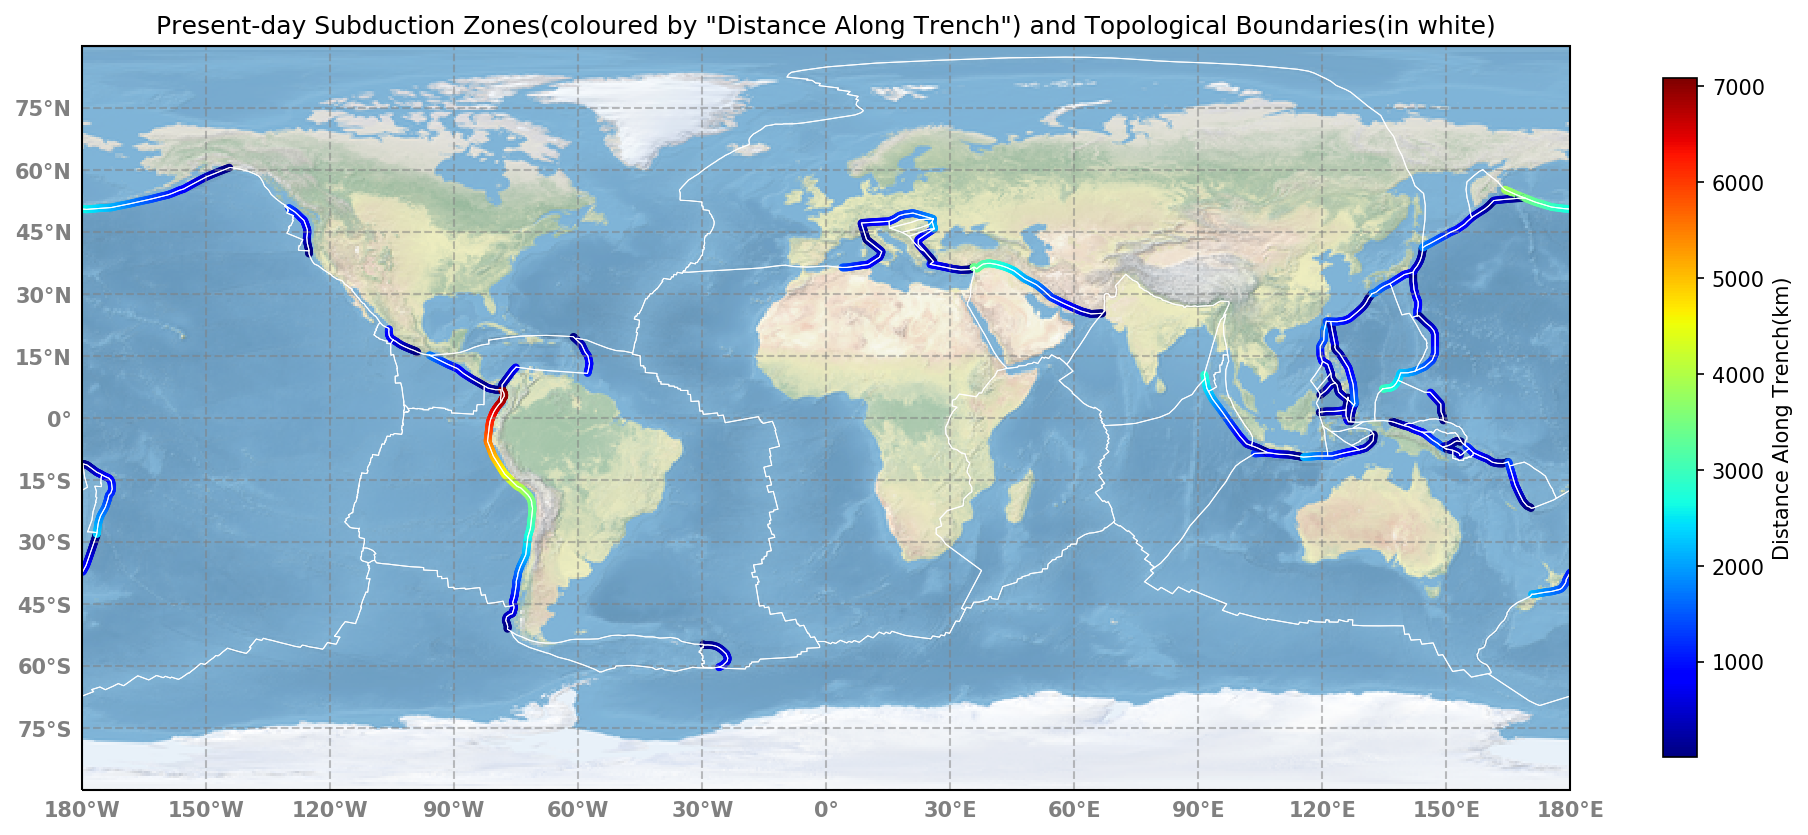

In [3]:
%matplotlib inline

import requests, os
import pygplates
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from parameters import parameters as p

trench_file = './convergence_data/subStats_0.00.csv'
trench_data= np.genfromtxt(trench_file)

#change this number to see the trench colored by different property. 
#The meaning of this number can be found in the Markdown cell above
color_by = 11

#get topological plates boundaries
time = 0
resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(p["topology_files"], p["rotation_files"], resolved_topologies, time, 
                             shared_boundary_sections)

geoms = [t.get_resolved_boundary() for t in resolved_topologies]           

#now, plot the data in a global map    
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
for geom in geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='white', linewidth=.5, #the topological plates boundaries in white
         transform=ccrs.Geodetic(),
    )
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

#the subduction sample points are colored by property value. see "color_by" above
cb=ax.scatter(trench_data[:,0], trench_data[:,1], 30, marker='.', 
              c=trench_data[:,color_by]* 6371. * np.pi / 180, cmap=plt.cm.jet)
plt.title('Present-day Subduction Zones(coloured by "Distance Along Trench") and Topological Boundaries(in white)')
fig.colorbar(cb, shrink=0.5, label='Distance Along Trench(km)')
plt.show()


##### Take a closer look at South America

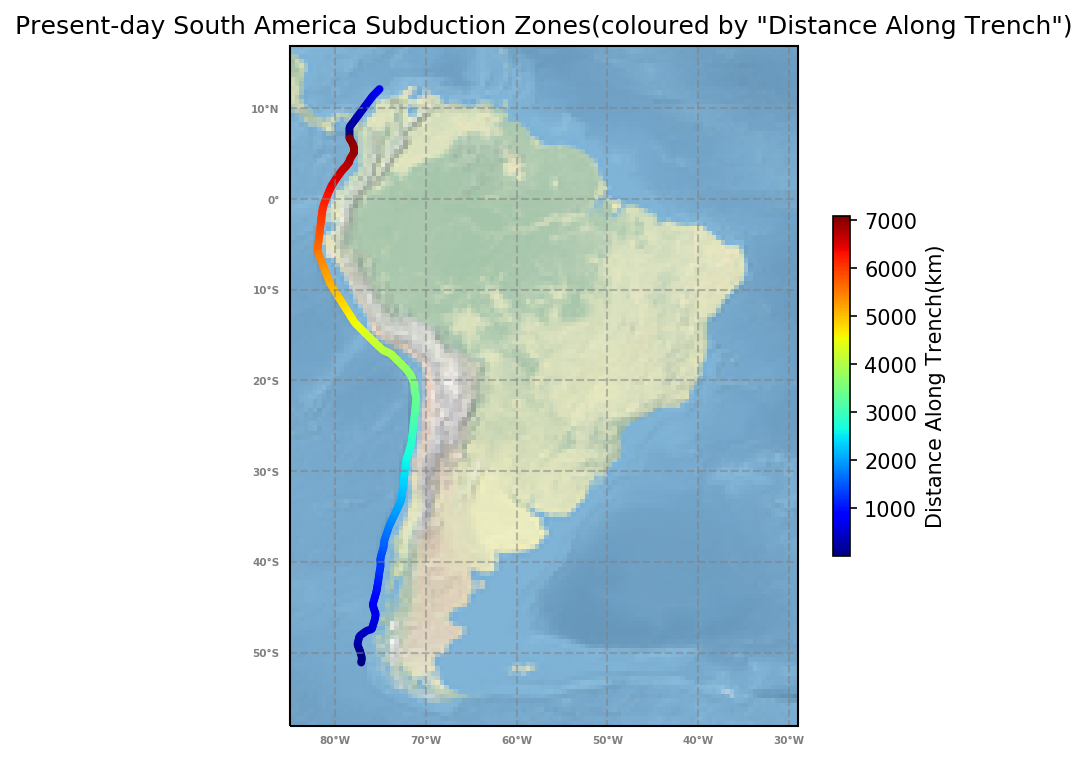

In [4]:
%matplotlib inline

#get South America trench data
trench_data=trench_data[(trench_data[:,9])==201]        

#now, plot the data in a regional map    
fig = plt.figure(figsize=(6,6),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-85, -29, -55, 15])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -80, -70, -60,-50,-40,-30, 0, 180])
gl.ylocator = mticker.FixedLocator([-90,-50,-40, -30, -20,-10, 0, 10, 20, 30, 40,50, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}

#the subduction sample points are colored by property value. see "color_by" above
cb=ax.scatter(trench_data[:,0], trench_data[:,1], 30, marker='.', 
              c=trench_data[:,color_by]* 6371. * np.pi / 180, cmap=plt.cm.jet)
plt.title('Present-day South America Subduction Zones(coloured by "Distance Along Trench")')
fig.colorbar(cb, shrink=0.5, label='Distance Along Trench(km)')
plt.show()


#### Plot a reconstruction map
This is a reconstructed map with a paleo-age grid, paleo-coastlines, plate boundaries and subduction teeth.

reconstructing geometries...


/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1752: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


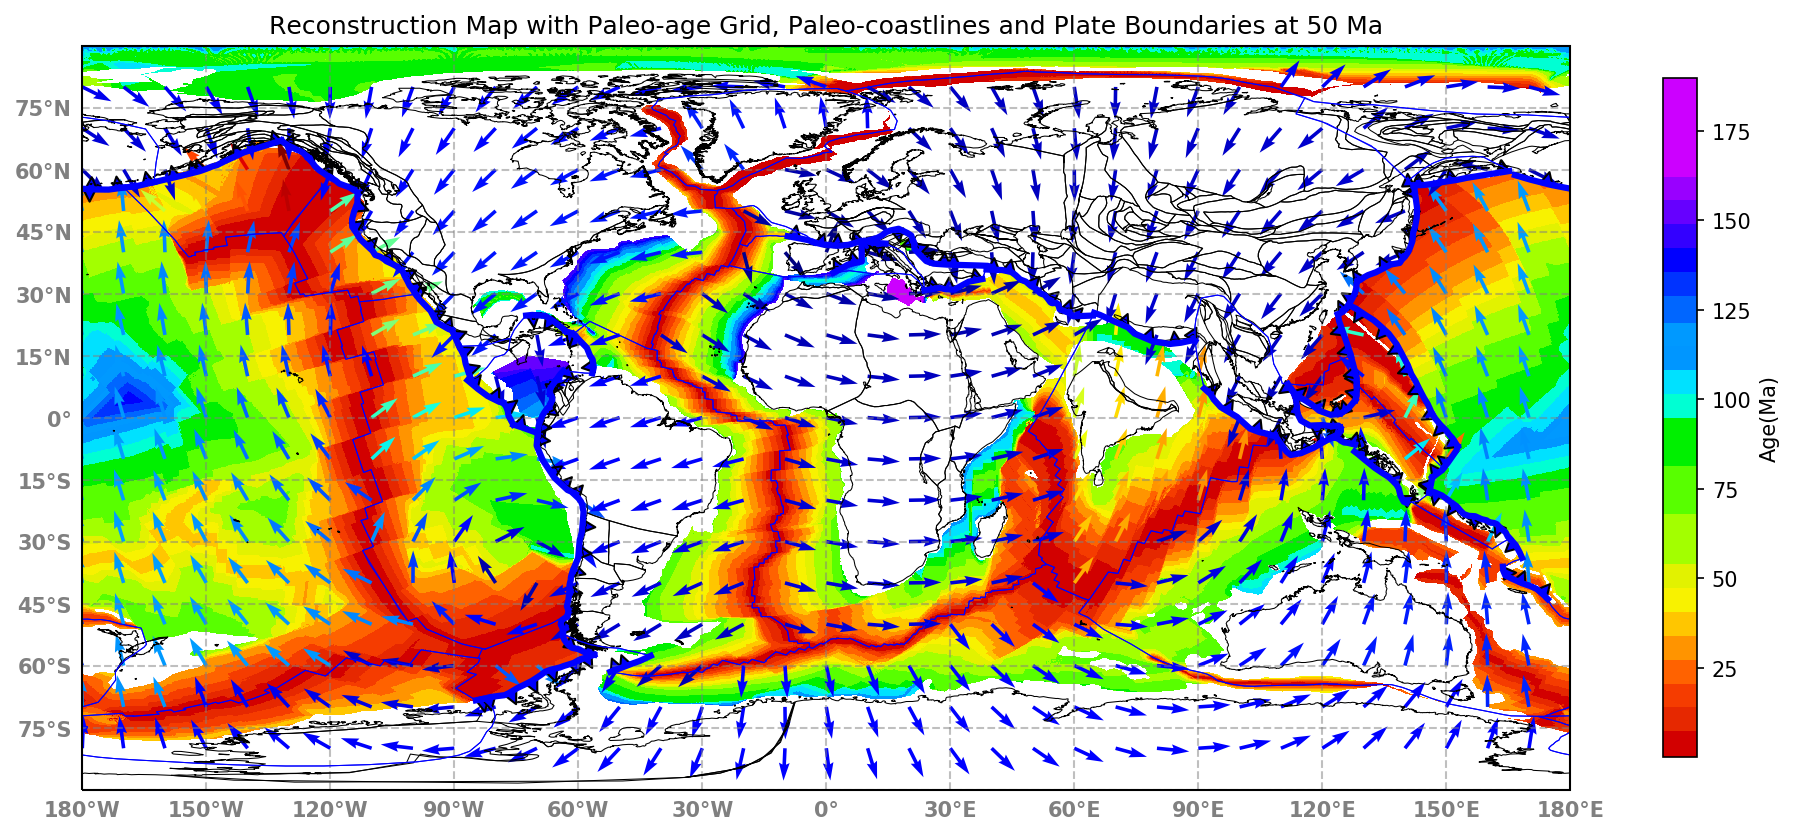

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from netCDF4 import Dataset
from shapely.geometry.polygon import LinearRing

import Utils, pygplates

time = 50
draw_velocity_vectors = True

#change the extent to see specific area
#map_extent = [-85, -30, -55, 15]
map_extent = [-180, 180, -90, 90]

agegrid_file = Utils.download_agegrid(time)
agegrid_cmap = Utils.get_age_grid_color_map_from_cpt('agegrid.cpt')

#reconstruct coastlines and topology
print("reconstructing geometries...")
data_dir = '../data/'

resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(p["topology_files"], p["rotation_files"], resolved_topologies, time, 
                             shared_boundary_sections)

#coastlines
reconstructed_geometries = []
pygplates.reconstruct(
                data_dir + 'Shapefiles/Coastlines/Global_coastlines_2015_v1_low_res.shp', 
                p["rotation_files"], 
                reconstructed_geometries, 
                time, 0)

#subduction zones
subduction_geoms=[]
Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)

#velocity vectors
x,y, u,v = Utils.get_velocity_x_y_u_v(time,pygplates.RotationModel(p["rotation_files"]),p["topology_files"])
       
# plot the map
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent(map_extent)
img = Dataset(agegrid_file) #age grid
cb=ax.imshow(np.roll(img.variables['z'],1800), origin='lower', transform=ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90], cmap=agegrid_cmap)

#plot coastlines
for geom in reconstructed_geometries:
    lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='black', linewidth=.5, #the coastlines in black
         transform=ccrs.Geodetic(),
    )

#plot topological plates boundaries
for t in resolved_topologies:
    lat, lon =zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='blue', linewidth=.5, #the topological plates boundaries in blue
         transform=ccrs.Geodetic(),
    )
 
#plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='blue', linewidth=3, #the subduction zones in blue
         transform=ccrs.Geodetic(),
    )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='b', edgecolor='black', alpha=1)

 
if draw_velocity_vectors:
    #draw the velocity vectors
    #Some arrows are long and some are very short. To make the plot clearer, we nomalize the velocity magnitude.
    #And use color to denote the different speed.
    u = np.array(u)
    v = np.array(v)
    mag = np.sqrt(u*u+v*v)
    u = u/mag
    v = v/mag
    ax.quiver(x, y, u, v, mag,transform=ccrs.PlateCarree(),cmap='jet')    

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

plt.title(f'Reconstruction Map with Paleo-age Grid, Paleo-coastlines and Plate Boundaries at {time} Ma')
fig.colorbar(cb, shrink=0.5, label='Age(Ma)')
plt.show()   
   


#### This is the end of step 1 and now open the step 2 notebook
[2_Plot_and_Select_Mineral_Resources.ipynb](2_Plot_and_Select_Mineral_Resources.ipynb)